In [12]:
import pandas as pd
import plotly.graph_objects as go
from collections import defaultdict
from s2sphere import CellId, LatLng, Cell

In [13]:
# http://s2geometry.io/about/overview
# http://s2geometry.io/devguide/s2cell_hierarchy.html
def adaptive_partition(df: pd.DataFrame, t1: int = 10_000, t2: int = 50, max_level: int = 18):
    all_cells = defaultdict(list)
    
    # Loop through all lat,lon values
    for _, row in df.iterrows():
        lat, lon = row['lat'], row['lon']
        latlng = LatLng.from_degrees(lat, lon)
        cell_id = CellId.from_lat_lng(latlng)
        
        # Add the lat,lon to be cells at each hierarchy
        for level in range(max_level + 1):
            parent = cell_id.parent(level)
            all_cells[parent.id()].append((lat, lon))
            
    final_cells = set()
    processed = set()
    
    def recurse(cell_id_val: CellId, depth: int):
        """Recursive function to calculate and slice cells of the grid"""
        # Cell already processed
        if cell_id_val in processed:
            return
        processed.add(cell_id_val)
        
        points_list = all_cells.get(cell_id_val, [])
        # No points exist in the cell
        if len(points_list) == 0:
            return
            
        # Not big enough to split or done splitting
        if len(points_list) <= t1 or depth >= max_level:
            # Only keep cells that contain enough points
            if len(points_list) >= t2:
                final_cells.add(cell_id_val)
            return
        
        # Too many points, recurse through each split of the cell
        cell_id_obj = CellId(cell_id_val)
        for i in range(4):
            child = cell_id_obj.child(i)
            recurse(child.id(), depth + 1)
    
    # Iterate through each level and recurve through the cells
    for level in range(max_level + 1):
        level_cells = [cid for cid in all_cells.keys() if CellId(cid).level() == level]
        for cell_id_val in level_cells:
            if cell_id_val not in processed:
                recurse(cell_id_val, level)
    
    return final_cells

def get_cell_vertices(cell_id_val: CellId):
    """Grabs all 4 vertices of a cell"""
    cell_id_obj = CellId(cell_id_val)
    cell = Cell(cell_id_obj)
    vertices = []
    for i in range(4):
        vertex = cell.get_vertex(i)
        latlng = LatLng.from_point(vertex)
        vertices.append((latlng.lat().degrees, latlng.lng().degrees))
    return vertices

In [14]:
sampled_df = pd.read_csv('../data/imgs/sampled.csv', index_col=0)
if 'lat' in sampled_df.columns and 'lon' in sampled_df.columns:
    sampled_df = sampled_df.drop(columns=['lat', 'lon'])
points_df = pd.read_csv('../data/points.csv')
points_df = points_df.rename(columns={'id': 'orig_id'})
points_df = points_df[['orig_id', 'lat', 'lon']]
city_df = pd.merge(sampled_df, points_df, on=['orig_id'])
print("Data shape:", city_df.shape)
display(city_df.head())

Data shape: (190693, 8)


,uuid,source,orig_id,city,country,iso3,lat,lon
0,99891cd8-bd32-4cc9-9e48-9d7fbdc30909,Mapillary,755195782374799,Washington,United States,USA,38.892015,-77.031205
1,0752026e-3449-4e9a-a75b-974e16738eca,Mapillary,3983548141753049,Washington,United States,USA,38.903943,-77.018739
2,7e2600a1-eaaf-4d91-8d4d-065984e90cde,Mapillary,233657401861198,Washington,United States,USA,38.899477,-77.031631
3,2e92aa72-215d-4672-aa1f-bcd71b02322d,Mapillary,958812788229569,Washington,United States,USA,38.902491,-77.029299
4,e9e94c21-5d7b-4f4d-9fb0-42c71745b376,Mapillary,287795916343455,Washington,United States,USA,38.893817,-77.015253


In [15]:
# t1=5_000, t2=50, max_level=30 for 1,000,000 looks pretty good
# Level 0: 6 cells
# Level 1: 24 cells
# ...
# Total cells = 6 * 4^level
max_level = 25
final_cells = adaptive_partition(city_df, t1=10000, t2=1000, max_level=max_level)

In [16]:
def latlon_to_cellid(lat: float, lon: float):
    """Find which final cell this lat/lon belongs to"""
    latlng = LatLng.from_degrees(lat, lon)
    cell_id = CellId.from_lat_lng(latlng)
    
    # Traverse from max_level down to find the corresponding cell
    # Each lat,lon only belongs to the highest level cell
    for level in range(max_level, -1, -1):
        parent = cell_id.parent(level)
        parent_id = parent.id()
        
        if parent_id in final_cells:
            return parent_id
    
    return None

def cellid_to_latlon(cell_id: int):
    """Get the center coordinate of a cell_id"""
    cell_id_obj = CellId(cell_id)
    latlon = cell_id_obj.to_lat_lng()
    return latlon.lat().degrees, latlon.lng().degrees

# Add the cell id corresponding to each latitude and longitude
city_df['s2_cell_id'] = city_df.apply(
    lambda row: latlon_to_cellid(row['lat'], row['lon']), 
    axis=1
)
city_df[['cell_lat', 'cell_lon']] = city_df['s2_cell_id'].map(cellid_to_latlon).apply(pd.Series)

# Remove null cell_ids
city_df.dropna(subset=['s2_cell_id'], inplace=True)
cell_ids = [int(id) for id in set(city_df['s2_cell_id'].unique())]
print(f"Number of unique cells: {len(cell_ids)}")

Number of unique cells: 144


In [17]:
def visualize_s2_cells(final_cells: set[CellId]):
    fig = go.Figure()
    
    for cell_id_val in final_cells:
        vertices = get_cell_vertices(cell_id_val)
        lats = [v[0] for v in vertices] + [vertices[0][0]]
        lons = [v[1] for v in vertices] + [vertices[0][1]]
        
        fig.add_trace(go.Scattergeo(
            lon=lons,
            lat=lats,
            mode='lines',
            line=dict(width=1, color='blue'),
            showlegend=False
        ))
    
    fig.update_layout(
        title=f'Adaptive S2 Cell Partitioning - {len(final_cells)} Cells',
        geo=dict(
            projection_type='natural earth',
            showland=True,
            showcountries=True,
        ),
        height=720,
        width=1280,
    )
    return fig

fig = visualize_s2_cells(cell_ids)
fig.show()

In [18]:
# Create the labels as a sequence from 0 to num_unique_cells
replacement_dict = dict()
for i, cell_id in enumerate(cell_ids):
    replacement_dict[cell_id] = i
    
city_df['label'] = city_df['s2_cell_id'].replace(replacement_dict).astype(int)
city_df.to_csv('../data/imgs/sampled.csv')
print(f"Number of unique cells: {len(city_df['s2_cell_id'].unique())}")
print(city_df['label'].unique())

Number of unique cells: 144
[  9  10   7   8   6  11  12  16  17  18  50  51  52  53  54  55  56  57
  58  59  74 126  70  38  85 140 138  86  13 131  24  25  94 120  36 137
  37  15 124 100  77 130  84 107  97   3 111  14  41 142 108  23  19  20
   4   5  42  43  44  80  45 109 112  46  47 114  21  48  40 110 113 115
 121 106  22  87  49  81 122 103 141  67  32 105  60 123  93  33  68 127
 134 135  26  82  79 128 101  27  61 118 116  78   0  34  75  88  98  35
  31  71  83 104  62 132  28  89  63  39  29 102  90  64 139 117 129  65
 136  72  99  95 125 133   1  73   2  69 119  91  96  30  92 143  76  66]


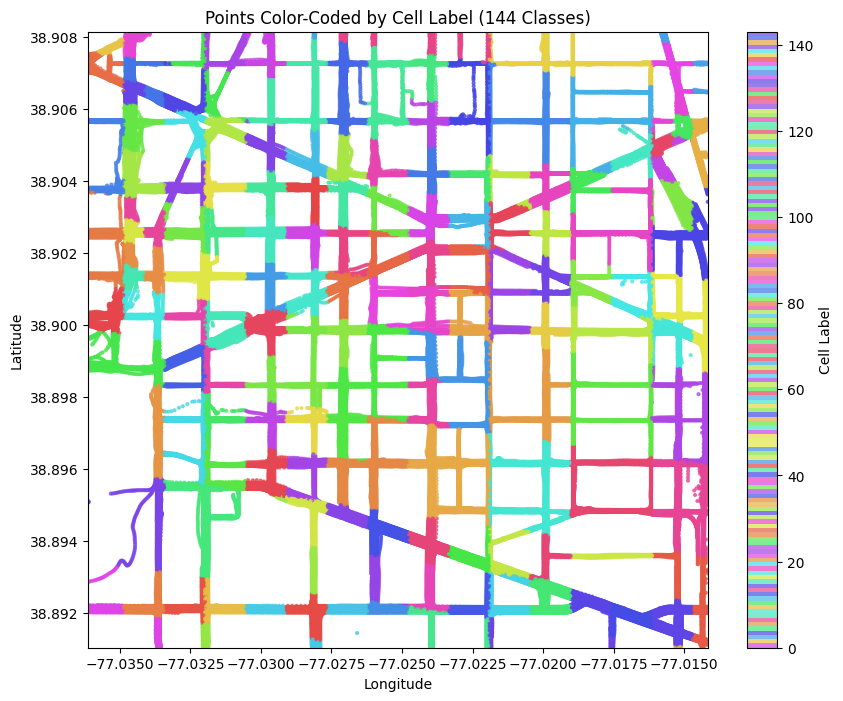

In [19]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def scatter_points_by_label(city_df: pd.DataFrame):
    plt.figure(figsize=(10, 8))
    num_labels = city_df['label'].nunique()
    
    # Generate unique colors for each label using HSV color space
    hues = np.linspace(0, 1, num_labels, endpoint=False)
    np.random.seed(42)
    np.random.shuffle(hues)  # Shuffle to avoid similar colors being adjacent
    colors = [mcolors.hsv_to_rgb([h, 0.7, 0.9]) for h in hues]
    cmap = mcolors.ListedColormap(colors)
    
    scatter = plt.scatter(
        city_df['lon'], city_df['lat'],
        c=city_df['label'], cmap=cmap, s=4, alpha=0.7
    )
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Points Color-Coded by Cell Label ({num_labels} Classes)')
    plt.xlim(city_df['lon'].min(), city_df['lon'].max())
    plt.ylim(city_df['lat'].min(), city_df['lat'].max())
    plt.colorbar(scatter, label='Cell Label')
    plt.show()

scatter_points_by_label(city_df)

In [20]:
# Output cell IDs ordered by the count of points in each cell
cell_counts = city_df.groupby('s2_cell_id').size().reset_index(name='count')
cell_counts_sorted = cell_counts.sort_values(by='count', ascending=False)
print(cell_counts_sorted)

              s2_cell_id  count
32   9923602134111092736   3010
31   9923602131963609088   2838
82   9923602168470831104   2674
38   9923602140553543680   2491
28   9923602125521158144   2379
..                   ...    ...
118  9923602340269522944    398
0    9923602085792710656    314
137  9923602563607822336    299
123  9923602523879374848     54
10   9923602094382645248     28

[144 rows x 2 columns]


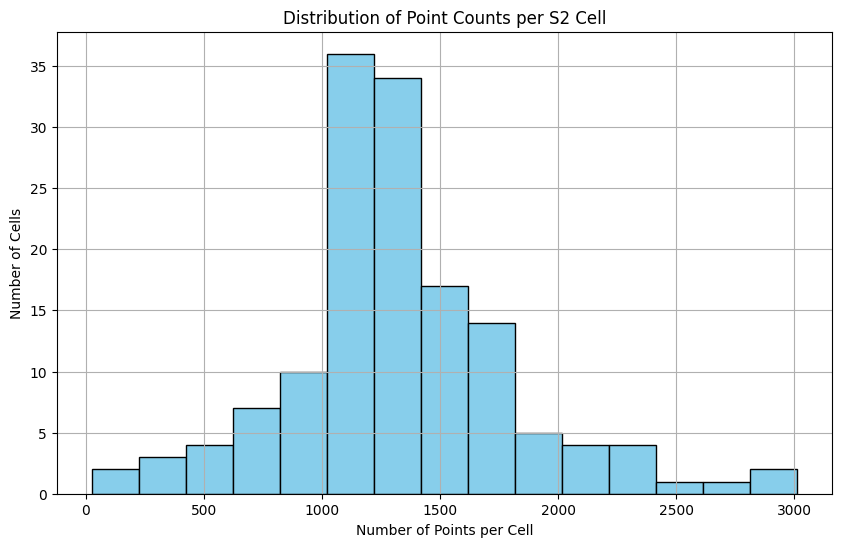

In [21]:
import matplotlib.pyplot as plt

# Plot the distribution of point counts per cell
plt.figure(figsize=(10, 6))
plt.hist(cell_counts_sorted['count'], bins=15, color='skyblue', edgecolor='black')
plt.xlabel('Number of Points per Cell')
plt.ylabel('Number of Cells')
plt.title('Distribution of Point Counts per S2 Cell')
plt.grid(True)
plt.show()

In [22]:
city_df

,uuid,source,orig_id,city,country,iso3,lat,lon,s2_cell_id,cell_lat,cell_lon,label
0,99891cd8-bd32-4cc9-9e48-9d7fbdc30909,Mapillary,755195782374799,Washington,United States,USA,38.892015,-77.031205,9923602171423621120,38.892258,-77.031259,9
1,0752026e-3449-4e9a-a75b-974e16738eca,Mapillary,3983548141753049,Washington,United States,USA,38.903943,-77.018739,9923602119347142656,38.903641,-77.018303,10
2,7e2600a1-eaaf-4d91-8d4d-065984e90cde,Mapillary,233657401861198,Washington,United States,USA,38.899477,-77.031631,9923602160686202880,38.899963,-77.031259,7
3,2e92aa72-215d-4672-aa1f-bcd71b02322d,Mapillary,958812788229569,Washington,United States,USA,38.902491,-77.029299,9923602151559397376,38.902370,-77.029819,8
4,e9e94c21-5d7b-4f4d-9fb0-42c71745b376,Mapillary,287795916343455,Washington,United States,USA,38.893817,-77.015253,9923602101898838016,38.894888,-77.014704,6
...,...,...,...,...,...,...,...,...,...,...,...,...
190688,5f3df207-7ea1-4ca3-903e-28fe515421f3,Mapillary,191049233384915,Washington,United States,USA,38.900626,-77.032031,9923602159880896512,38.899402,-77.031978,86
190689,2dac5a44-2c91-4cad-9a81-14aa3efc3817,Mapillary,844106819523929,Washington,United States,USA,38.892058,-77.026238,9923602183771652096,38.891771,-77.026940,77
190690,c55ead62-5a8e-42cb-bd93-18fd65c4a1eb,Mapillary,759825062099889,Washington,United States,USA,38.903702,-77.016168,9923602119078707200,38.902918,-77.017583,18
190691,e1ac196d-d1c3-4e7a-b64d-08292c93784b,Mapillary,943086756453211,Washington,United States,USA,38.892577,-77.018909,9923602088745500672,38.892083,-77.018303,132
